In [1]:
!pip install statsmodels
!pip install pmdarima

     |████████████████████████████████| 9.5MB 15.7MB/s eta 0:00:01
     |████████████████████████████████| 235kB 57.4MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 2.0MB 64.8MB/s eta 0:00:01
     |████████████████████████████████| 14.8MB 59.1MB/s eta 0:00:01
  Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [7]:
from hdfs import InsecureClient
client = InsecureClient('http://datalake:50070')

client.status("/")
with client.read('/shared/havells_trail/raw/TSA.csv', encoding = 'utf-8') as reader:
    df = pd.read_csv(reader, sep=",",parse_dates=['calendar_year_month'],index_col='calendar_year_month')

In [8]:
df.head()

,qty_final
calendar_year_month,
2016-01-01,5945.0
2016-02-01,5685.0
2016-03-01,5690.0
2016-04-01,7344.0
2016-05-01,9419.0


## Plotting the dataframe

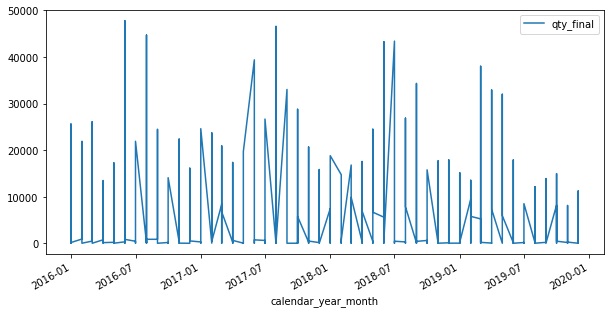

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
df.plot()
plt.show()

In [15]:
## We can see the repaeted patterns i.e seasonality in the plot

## Decomposing the timeSeries

In [31]:
df_add_decompose=seasonal_decompose(df,model='additive',period=1)  #additive decomposing

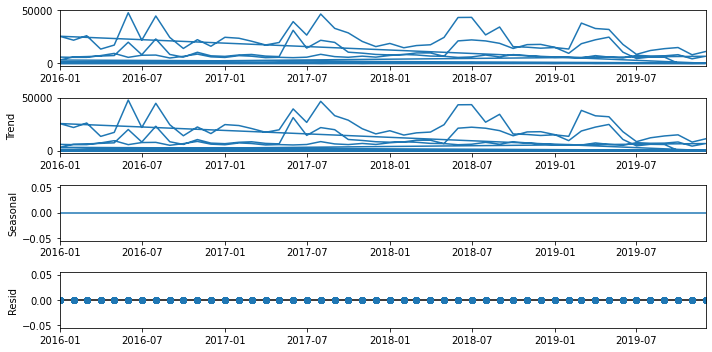

In [32]:
df_add_decompose.plot()
plt.show()

In [25]:
## Multiplicative Decomposing

In [34]:
df_multi_decompose=seasonal_decompose(df,model='multiplicative',period=1)

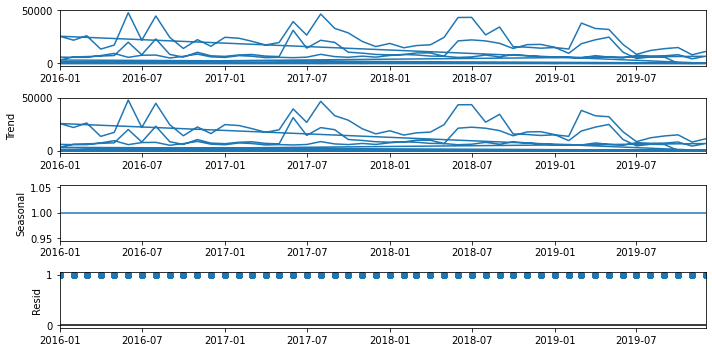

In [35]:
df_multi_decompose.plot()
plt.show()

In [36]:
##applying log transformation

In [37]:
df_log=df.copy()
df_log['qty_final']=np.log(df)

In [38]:
df_log.qty_final

calendar_year_month
2016-01-01    8.690306
2016-02-01    8.645586
2016-03-01    8.646466
2016-04-01    8.901639
2016-05-01    9.150484
                ...   
2019-08-01    9.406729
2019-09-01    9.540004
2019-10-01    9.612667
2019-11-01    9.002701
2019-12-01    9.322239
Name: qty_final, Length: 480, dtype: float64

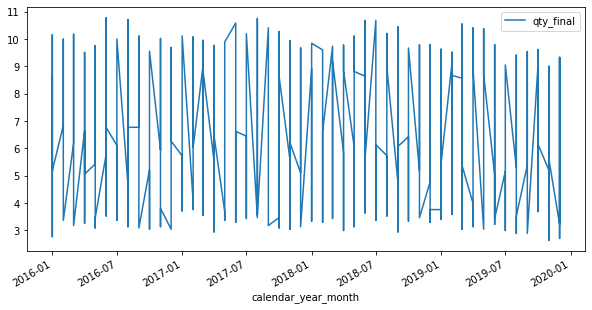

In [39]:
df_log.plot()
plt.show()

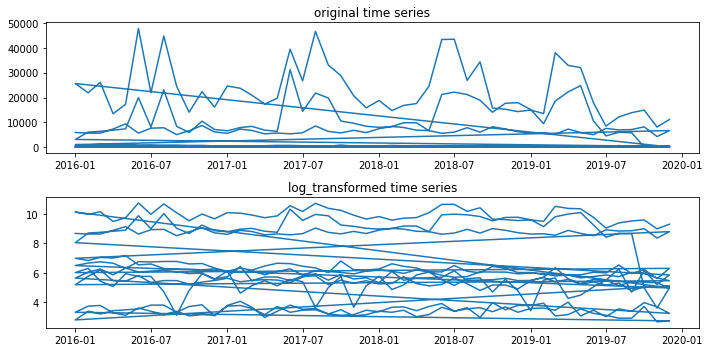

In [40]:
plt.subplot(2,1,1)
plt.title('original time series')
plt.plot(df)
plt.subplot(2,1,2)
plt.title('log_transformed time series')
plt.plot(df_log)
plt.tight_layout()

In [41]:
##Splitting the data into train and test

In [44]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from IPython.display import display
from sklearn.metrics import mean_squared_error
import statsmodels.tools.eval_measures as em

In [45]:
## SPLITTING THE DATA INTO TRAIN AND TEST

In [55]:
train=df[df.index<='2018']
test=df[df.index>'2018']

In [56]:
model_ses=SimpleExpSmoothing(train)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


In [57]:
model_ses_autofit=model_ses.fit(optimized=True)

In [58]:
model_ses_autofit.params

{'smoothing_level': 0.32732558139534884,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 5945.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [59]:
ses_predict=model_ses_autofit.forecast(len(test))
ses_predict

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


250    22360.26313
251    22360.26313
252    22360.26313
253    22360.26313
254    22360.26313
          ...     
475    22360.26313
476    22360.26313
477    22360.26313
478    22360.26313
479    22360.26313
Length: 230, dtype: float64

## plotting

Text(0.5, 1.0, 'alpha=0.327 predictions')

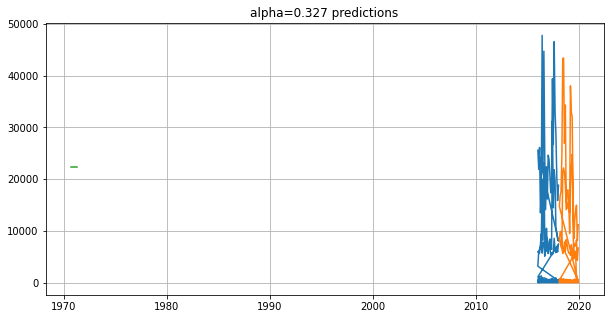

In [60]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(ses_predict,label='alpha=0.327')
plt.grid()
plt.title('alpha=0.327 predictions')

In [61]:
## Calculating the mean squared error

In [64]:
print('mse',mean_squared_error(test.values,ses_predict.values,squared=False))

mse 19872.069494402826


## Holt method

In [65]:
model_holt=Holt(train)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


In [66]:
model_holt=model_holt.fit()
model_holt.params

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.3114285714285714,
 'smoothing_trend': 0.013540372670807451,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 5945.0,
 'initial_trend': -260.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [67]:
holt_predict=model_holt.forecast(len(test))
holt_predict

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


250    23357.328134
251    23533.215328
252    23709.102522
253    23884.989716
254    24060.876910
           ...     
475    62931.946788
476    63107.833982
477    63283.721176
478    63459.608370
479    63635.495564
Length: 230, dtype: float64

Text(0.5, 1.0, 'predictions')

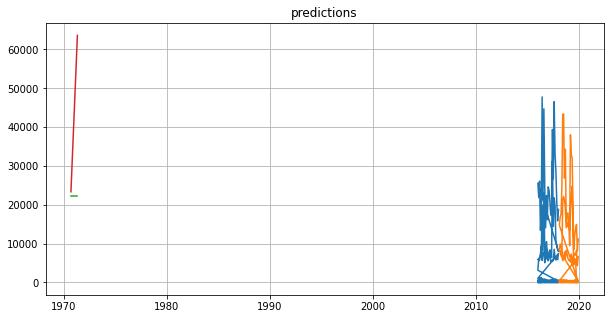

In [68]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(ses_predict,label='alpha=0.327')
plt.plot(holt_predict,label='alpha=0.311,beta=0.013')
plt.grid()
plt.title('predictions')

In [69]:
print('mse',mean_squared_error(test.values,holt_predict.values,squared=False))

mse 40756.94374828652


## Holt_winters

In [72]:
model_tes=ExponentialSmoothing(train,trend='additive',seasonal='additive',seasonal_periods=12)
model_tes=model_tes.fit()
model_tes.params

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'smoothing_level': 0.11107142857142857,
 'smoothing_trend': 0.04936507936507936,
 'smoothing_seasonal': 0.5596957671957672,
 'damping_trend': nan,
 'initial_level': 3242.6666666666665,
 'initial_trend': -45.111111111111114,
 'initial_seasons': array([2702.33333333, 2442.33333333, 2447.33333333, 4101.33333333,
        6176.33333333, 2449.33333333, 4440.33333333, 4605.33333333,
        1844.33333333, 3422.33333333, 5509.33333333, 2916.33333333]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [73]:
tes_predict=model_tes.forecast(len(test))
tes_predict

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


250     27705.928536
251     27101.672135
252     22219.032977
253     28093.948450
254     45159.544699
           ...      
475    104792.275961
476    100694.006962
477    113353.563828
478    112045.432871
479    111441.176470
Length: 230, dtype: float64

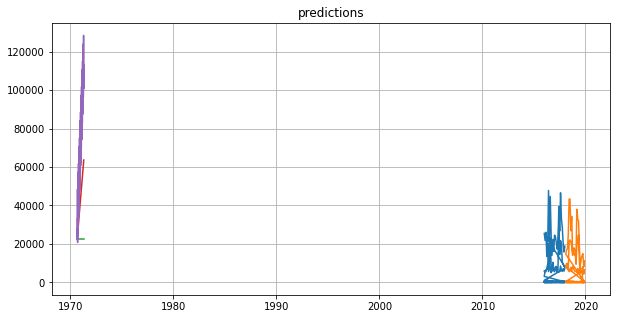

In [75]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(ses_predict,label='alpha=0.327')
plt.plot(holt_predict,label='alpha=0.311,beta=0.013')
plt.plot(tes_predict,label='alpha,beta,gamma')
plt.grid()
plt.title('predictions')
plt.show()

In [76]:
print('mse',mean_squared_error(test.values,tes_predict.values,squared=False))

mse 71064.43045644327


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.qty_final   No. Observations:                  479
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4643.477
Method:                       css-mle   S.D. of innovations           3922.775
Date:                Fri, 06 Aug 2021   AIC                           9300.953
Time:                        09:41:03   BIC                           9330.155
Sample:                             1   HQIC                          9312.433
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.6433     91.174      0.106      0.916    -169.055     188.342
ar.L1.D.qty_final    -0.4199      0.046     -9.204      0.000      -0.509      -0.330
ar.L2.D.qty_final    -0.

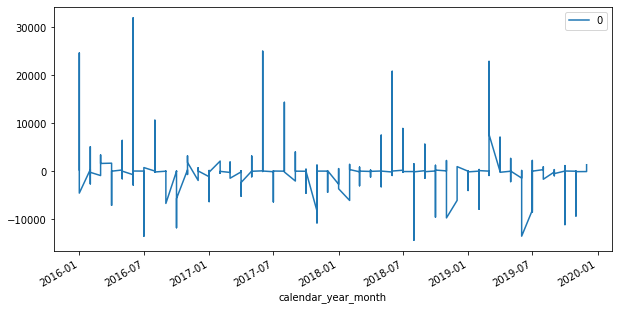

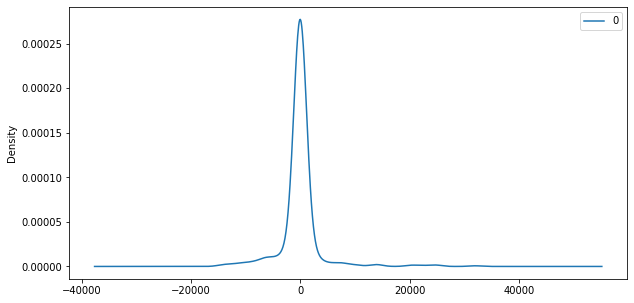

                  0
count    479.000000
mean       1.497805
std     3927.147806
min   -14453.506455
25%     -139.291501
50%      -23.650845
75%       45.381556
max    31990.642966


In [92]:
from matplotlib import pyplot
model = ARIMA(df, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [95]:
import pickle
pickle.dump(model_fit, open("forecast_lm1.pickle.dat", "wb"))